In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


So, I managed to apply the Salpeter -> Chabrier conversion in the wrong direction and now the number counts won't add up unless we re-fit M\*-MUV.  This was done by using an anchor at z~4 for the slope, intercept and scatter that would convert between the Bouwens luminosity function, and the chosen mass function.

We have some choices to make about the exact form of the fitting but for now I want to write the program that determines this anchor.  

In [2]:
def schechterMUV(Marr,modelParams):
    phi = (np.log(10)/2.5)*modelParams['phiStar']*\
          np.power(10,(-0.4)*(Marr-modelParams['logMstar'])*(1+modelParams['alpha']))*\
          np.exp((-1)*np.power(10,(-0.4)*(Marr-modelParams['logMstar'])))
    return np.log10(phi)

def schechter(Marr,modelParams):
    phi = np.log(10)*modelParams['phiStar']*\
          np.power(10,(Marr-modelParams['logMstar'])*(1+modelParams['alpha']))*\
          np.exp((-1)*np.power(10,(Marr-modelParams['logMstar'])))
    return np.log10(phi)

The Bouwens 2016 luminosity function at z~4 has
* M\* = -20.88
* phi\* = 1.97E-3
* alpha = -1.64

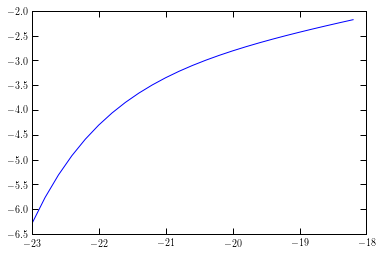

In [73]:
MUVarr=np.fromiter((x for x in np.arange(-23,-18,0.2)),np.float)
def params_bouwens(redshift,dmstar, dphistar):
    return {'logMstar':(-20.95 + dmstar) + (0.01) * (redshift -  6.0), \
            'phiStar': (0.47 - dphistar) * 10**(-0.27 * (redshift - 6.0)) * (10**-3.0), \
            'alpha':-1.87 + (-0.1 * (redshift - 6.0))}

bouwens_z4 = params_bouwens(4,0.02,0.06)
lumFn = schechterMUV(MUVarr,bouwens_z4)
pylab.plot(MUVarr, lumFn)

In [74]:
import scipy.interpolate as interpolate
import trapZ 
def inv_cdf_LumFn(modelParams, MUV_min, MUV_max):
    #split MUV range int 10000 bins
    MUVarr = np.fromiter((x for x in np.arange(MUV_min,MUV_max,(MUV_max-MUV_min)/1000.)),np.float)
    lumFn = 10**schechterMUV(MUVarr, modelParams)
    cumFn = np.zeros(len(MUVarr))
    for i in range(1,len(MUVarr)):
        cumFn[i] = trapZ.trapZ(MUVarr[:i],lumFn[:i])
    nPerVolElement = np.max(cumFn)
    cumFn = cumFn/np.max(cumFn)
    pylab.scatter(cumFn, MUVarr)
    inv_cdf = interpolate.interp1d(cumFn, MUVarr)
    pylab.plot(cumFn, inv_cdf(cumFn))
    return inv_cdf,nPerVolElement


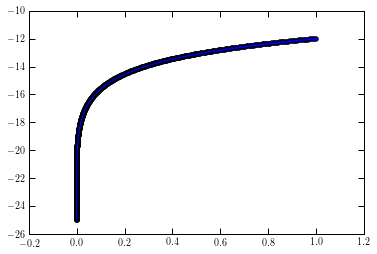

In [75]:
cumFn,nPerVolElementMUV = inv_cdf_LumFn(bouwens_z4, -25,-12)


In [76]:
def doubleSchechter(Marr,modelParams):
    phi = np.log(10)*np.exp((-1)*np.power(10,(Marr-modelParams['logMstar'])))*\
          np.power(10,(Marr-modelParams['logMstar'])) * \
          (10**modelParams['phiStar1']*np.power(10,((Marr-modelParams['logMstar'])*modelParams['alpha1'])) + \
           10**modelParams['phiStar2']*np.power(10,((Marr-modelParams['logMstar'])*modelParams['alpha2'])))
    return np.log10(phi)

In [132]:

def smoothMF(z):
   
#plus my MF
    a0=10.5851169298
    a1=-0.102578734948
    b0= -2.74364185505
    b1= 0.139969051621
    b2=  -0.337435294239
    c0= -1.36239086197
    c1=  1.26032140118
    d0=  0.439639772964
    d1=-1.1
    d2=  -3.5836143076
    e0=  0.254735087692
    e1=-1.1
    e2=  -1.71040802844
    
    modelParams = {'logMstar':a0+a1*z, \
                   'phiStar1':b0+b1*z+b2*z**2, \
                   'alpha1':c0+c1*z, \
                   'phiStar2':d0*(1-np.exp(d1*z))+d2, \
                   'alpha2': e0*(1-np.exp(e1*z))+e2}
    
#     #I get a better fit with the following tweak
#     modelParams = {'logMstar':a0+a1*z, \
#                    'phiStar1':b0+b1*z+b2*z**2+0.5, \
#                    'alpha1':c0+c1*z+0.5, \
#                    'phiStar2':d0*(1-np.exp(d1*z))+d2-0.15, \
#                    'alpha2': e0*(1-np.exp(e1*z))+e2-0.03}
    return modelParams


In [133]:
def inv_cdf_MassFn(modelParams, mass_min, mass_max):
    #split MUV range int 10000 bins
    massArr = np.fromiter((x for x in np.arange(mass_min,mass_max,(mass_max-mass_min)/1000.)),np.float)
    #should be integrated from high to low mass
    print massArr[:10]
    massArr = massArr[::-1]
    print massArr[:10]
    massFn = 10**doubleSchechter(massArr, modelParams)
    cumFn = np.zeros(len(massArr))
    for i in range(1,len(massArr)):
        cumFn[i] = trapZ.trapZ(massArr[:i],massFn[:i])
    nPerVolElement = np.max(cumFn)
    cumFn = cumFn/np.max(cumFn)
    #pylab.plot(massArr, cumFn)
    inv_cdf = interpolate.interp1d(cumFn, massArr)
    return inv_cdf,nPerVolElement

In [134]:
mf_z4 = smoothMF(4)
inv_cdf_mass,nPerVolElement = inv_cdf_MassFn(mf_z4, 6, 13)

[ 6.     6.007  6.014  6.021  6.028  6.035  6.042  6.049  6.056  6.063]
[ 12.993  12.986  12.979  12.972  12.965  12.958  12.951  12.944  12.937
  12.93 ]


In [135]:
def assignMUV(massArr, slope, intercept, scatter):
    randomArr = np.random.normal(size=len(massArr), scale=scatter)
    MUV = slope*massArr+intercept+randomArr
    return MUV

# def assignMass_flat(MUVarr, slope, intercept, scatter, scatter2, pivotMagnitude):
#     randomArr = np.random.normal(size=len(MUVarr), scale=scatter)
#     #make scatter increase at certain point
#     mass = slope*MUVarr+intercept+randomArr
#     tempIdx = np.where(MUVarr <pivotMagnitude)
#     mass[tempIdx[0]] = slope*pivotMagnitude+intercept+\
#                         np.random.normal(size=len(tempIdx[0]), scale=scatter2)
#     return mass

In [136]:
import cosmolopy.distance as cd

def integrateLumFn(modelParams, MUV1, MUV2):
    n = 100.
    dMUV = (MUV2 - MUV1)/n
    mArr = np.fromiter((x for x in np.arange(MUV1,MUV2,dMUV)), np.float)
    phi = np.power(10,schechterMUV(mArr,modelParams))
    totalN = 0.
    for i in range(np.int(n)):
        totalN = totalN + phi[i]*dMUV
    return totalN 

def integrateVolume(N_per_Mpc3, z1, z2, dx):
    #expecting dx in arcminutes 
    area_arcsec2 = (dx*60)**2
    #1 steradian = 1 rad2 = 3282.8 deg2 = 4.25E10 arcsec2
    area_solidAngle = area_arcsec2/4.25E10
    n = 10000.
    dz = (z2-z1)/n
    zArr = np.fromiter((x for x in np.arange(z1,z2,dz)), np.float)
    
    cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'h' : 0.7}
    cosmo = cd.set_omega_k_0(cosmo)
    totalVol = 0.
    totalN = 0.
    for i in range(np.int(n)):
        dVc = cd.diff_comoving_volume(zArr[i], **cosmo)
        V = dVc * area_solidAngle * dz
        totalVol = totalVol + V
        totalN = totalN + N_per_Mpc3 * V
        
    return totalVol,totalN

def integrateVolume_model(modelParams, z1, z2, M1, M2, dx):
    #expecting dx in arcminutes 
    area_arcsec2 = (dx*60)**2
    #1 steradian = 1 rad2 = 3282.8 deg2 = 4.25E10 arcsec2
    area_solidAngle = area_arcsec2/4.25E10
    n = 10000.
    dz = (z2-z1)/n
    zArr = np.fromiter((x for x in np.arange(z1,z2,dz)), np.float)
    
    cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'h' : 0.72}
    cosmo = cd.set_omega_k_0(cosmo)
    totalVol = 0.
    totalN = 0.
    for i in range(np.int(n)):
        dVc = cd.diff_comoving_volume(zArr[i], **cosmo)
        massFn_SF = {'logMstar':modelParams['a0'], \
         'phiStar1':modelParams['b0'] + modelParams['b1']*zArr[i] + modelParams['b2']*zArr[i]**2, \
         'alpha1':modelParams['c0'] + modelParams['c1']*zArr[i], \
         'phiStar2':modelParams['d0'] + modelParams['d1']*zArr[i] + modelParams['d2']*zArr[i]**2 , \
         'alpha2':modelParams['e0'] + modelParams['e1']*zArr[i] + modelParams['e2']*zArr[i]**2}
        N_per_Mpc3 = integrateLumFn(massFn_SF, M1, M2)
        V = dVc * area_solidAngle * dz
        totalVol = totalVol + V
        totalN = totalN + N_per_Mpc3 * V
        
    return totalVol,totalN
    

-4.4856309


/Users/efcl2/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in log10


5.875 6.0 0.117096220561 0.000337322079002
6.125 6.25 0.0909058368443 0.000331895586012
6.375 6.5 0.0703225046984 0.00026264167794
6.625 6.75 0.0543622222699 0.000278539774017
6.875 7.0 0.041844394275 0.000237253506438
7.125 7.25 0.0323147864198 0.000272109305691
7.375 7.5 0.024790431553 0.000206984009264
7.625 7.75 0.0191078467169 0.00018189594948
7.875 8.0 0.0144847969995 0.000113297015869
8.125 8.25 0.0108354021129 0.0001691083397
8.375 8.5 0.00812034337109 0.000121678346719
8.625 8.75 0.00594436450904 0.000126995530327
8.875 9.0 0.00427849386334 0.000103627381838
9.125 9.25 0.00296752609433 7.49538777413e-05
9.375 9.5 0.00196800370691 3.11711677793e-05
9.625 9.75 0.00124164271729 5.90433425234e-05
9.875 10.0 0.000738777416789 2.81172606157e-05
10.125 10.25 0.000408707394442 1.99147260833e-05
10.375 10.5 0.000194524025709 2.87610007592e-05
10.625 10.75 0.000100366119648 1.35952160367e-05
10.875 11.0 2.79369611391e-05 8.57243176601e-06
11.125 11.25 1.03470226441e-05 4.11806301694e-06

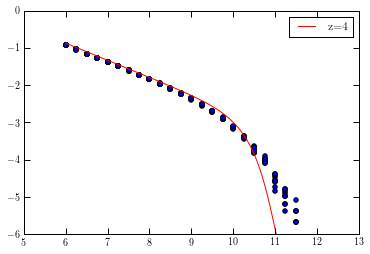

In [137]:
#so I'm going to make measurements for the bouwens z~4 LF transformed into a mass function 
#using our measured M*-MUV relation

deltaBin=0.25
binsIn = np.fromiter((x for x in np.arange(6,12,deltaBin)),np.float)-deltaBin/2.
nIter = 10 #100
plotMF = True

a = -0.16187211
b = -0.1937859
c = -4.4856309

z=4
current_M_MUV_intercept_z4 = a * (z-4)**2 + (b - 2*a*(z-4)) * (z-4) + c
print current_M_MUV_intercept_z4
slope = -1.655536222 
current_M_MUV_intercept_z4 = current_M_MUV_intercept_z4 - 0.2
    
# slope_z3 = 0.00903623 * 3**3  - 1.98027122
# intercept_z3 = -2.1197531  * 3 + 2.50955433
slope_z3 = slope
intercept_z3 = current_M_MUV_intercept_z4
outputMF = np.zeros([len(binsIn)-1,nIter])

for j in range(nIter):
    nObj = 1000000
    r = np.random.rand(nObj)
    outputMUV = cumFn(r)
    volMUV = nObj/nPerVolElementMUV


    mass_bouwens_lf_flat = assignMUV(outputMUV, 1/slope_z3, \
                                 (-1)*intercept_z3/slope_z3, 0.426)


    bins = np.histogram(mass_bouwens_lf_flat,bins=binsIn)
    outputMF[:,j] = bins[0]/deltaBin/volMUV
    if plotMF:
        pylab.scatter(bins[1][:-1]+deltaBin/2., np.log10(bins[0]/volMUV/deltaBin))
    else:
        pylab.scatter(mass_bouwens_lf_flat, outputMUV)
    

if not plotMF:
    pylab.scatter(data[1].data['mstar'][tempIdx[0]],data[1].data['MUV'][tempIdx[0]], c='r')
else:
    pylab.plot(np.arange(6,12,0.01), doubleSchechter(np.arange(6,12,0.01), mf_z4),\
               c='r', label="z=4")
    
legend()
pylab.ylim(-6,0)
tempMarr = np.fromiter((x for x in np.arange(6,12,0.1)),np.float)
avgMF = []
avgMF_err = []
for i in range(len(bins[0])):
    print bins[1][i], bins[1][i]+deltaBin/2., np.median(outputMF[i,:]), np.std(outputMF[i,:])
    avgMF.append(np.median(outputMF[i,:]))
    avgMF_err.append(np.std(outputMF[i,:]))


In [65]:
print mf_z4

{'alpha2': -1.4888004100048329, 'logMstar': 10.174801990008, 'alpha1': 3.67889474275, 'phiStar1': -7.58273035639, 'phiStar2': -3.3493721415635873}
